# Powtórzenie:
* Idea uczenia maszynowego
* główna idea SVM
* separowalność liniowa
* funkcje jadrowe
* problem pierwotny i dualny, Lagrangian
* minimalna optymalizacja osiowa



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Wstęp

* Drzewa decyzyjne to popularne narzędzia do “data mining” 
* Nadają się szczególnie dobrze do klasyfikacji, ale można je też przystosować do problemów regresji. 
* My skupimy się na ich zastosowaniach w klasyfikacji (podjęcia decyzji).

# Cechy algorytmów drzewiastych:
* łatwe do zrozumienia
* generują wyjście, które jest łatwo interpretować
* dość łatwe w użyciu -> niezbyt dużo parametrów do dopasowywania zanim uda się z nich wycisnąć coś użytecznego
* dobrze skalowalne
* są algorytmem typu “white box” - można łatwo wizualizować wiedzę, której wyuczył się algorytm
* mogą działać zarówno z danymi numerycznymi/ciągłymi jak i kategorycznymi/dyskretnymi
* algorytmy są typu “konstrukcyjnego poszukiwania” - drzewa “rosną” dopasowując się do danych 
* najczęściej uczone są “wsadowo” (batch mode)

# Jak można wyobrażać sobie drzewo decyzyjne 
* składa się z węzłów
* w danym węźle testowana jest wartość jednej cechy z przykładu uczącego 
* węzeł ma rozgałęzienia zależne od wyniku testu

## Przykład z decyzją o spacerze 
* Załóżmy, że chdzimy na spacer w zależności od pogody. 
* Zobaczmy jak może wyglądać drzewo opisujące podejmowanie decyzji o spacerze. 
* Drzewo takie budujemy w oparciu o zastaw wcześniejszych obserwacji różnych parametrów (cech) i podjętych decyzji. Innymi słowy mamy **zbiór uczący**.
* cechy (wejście): (Zachmurzenie{słonecznie, pochmurno, pada}, temperatura, wilgotność, wiatr)
* wyjście: tak/nie

![](1024px-Drzewo1.svg.png)

* cechy, np. temperatura, nie musi być istotna
* nie wszystkie cechy muszą być wykorzystane w drzewie decyzyjnym, może to wynikać z tego, że cechy są skorelowane/redundantne albo po prostu okazać się nieistotne dla problemu
* jednym z ważnych pytań, które tu się pojawiają jest to w jakiej kolejność wybierać cechy -> intuicja: od najbardziej informatywnych, tych które najszybciej prowadzą do decyzji
* jeśli cechy są ciągłe to można wprowadzić próg -> np. wilgotność (próg =75%) , wiatr(próg 20km/h)

# Podział przestrzeni cech
* W drzewach decyzyjnych granice między klasami mają postać hiperpowierzchni równoległych do osi cech 

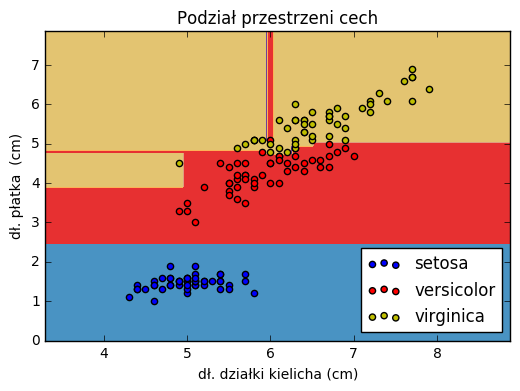

In [2]:


# Parameters
n_classes = 3
plot_colors = "bry"
plot_step = 0.02

# Load data
iris = load_iris()
iris.feature_names = ['dł. działki kielicha (cm)', 'szer. działki kielicha (cm)', 'dł. płatka  (cm)', 'szer. płatka (cm)']
pair = [0,2]
X = iris.data[:, pair]
y = iris.target

# Train
clf = DecisionTreeClassifier().fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.xlabel(iris.feature_names[pair[0]])
plt.ylabel(iris.feature_names[pair[1]])
plt.axis("tight")

    # Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i], cmap=plt.cm.Paired)
plt.title("Podział przestrzeni cech")
plt.legend(loc='lower right')
plt.show()


> ciężko jest nauczyć separacji klas, które na płaszczyźnie są separowane pochyłą prostą

* mając dużo danych można taką prostą aproksymować wieloma schodkami (przykład z podziałem przestrzeni 2D na prostokąty )
* w rzeczywistych zastosowaniach, gdy mamy wielowymiarowe cechy a dane są dość rzadkie, zwykle da się poprowadzić hiperpowierzchnie

## Czy można wyuczyć drzewo dowolnej funkcji logicznej?

* tak bo funkcje logiczne można reprezentować za pomocą tablic prawdy (matryc logicznych)

| A | B | A or B |
|---|---|:------:|
| 0 | 0 |    0   |
| 0 | 1 |    1   |
| 1 | 0 |    1   |
| 1 | 1 |    1   |

![](Drzewo_OR.png)

# Jak uczyć drzewo?

## Zarys algorytmu
* Załóżmy, że mamy kryterium $S$, które powie jak bardzo istotna jest dana cecha $c$ (To kryterium, to funkcja $S(c)$, która jest tym większa im bardziej istotna jest cecha)
* zaczynamy od korzenia i pełnego zbioru danych 
  * obliczamy $\arg \max_c S(c)$
  * na razie załóżmy, że cecha c jest logiczna: 0 lub 1, 
     * jeśli wartość wybranej cechy jest 0 to idziemy na lewo (i zostaje nam tylko pewien podzbiór danych) 
     * w przeciwnym razie (jeśli 1) to idziemy na prawo (i też pozostaje nam podzbiór - pozostała część)
     * w tym miejscu mówimy sobie, że ten podzbiór, który nam pozostał to cały zbiór -> rekurencja
     * rekurencyjnie podążamy tak długo aż:
       * zostaje nam podzbiór, który należy tylko do jednej klasy
       * nie mamy już cech, którymi można by zróżnicować przykłady

W pseudokodzie wygląda to tak:
* Oznaczenia:
  * `D` - dane treningowe
  * `x` - wektor wszystkich cech
  * `x_j` - pojedyncza cecha, j-ta współrzędna wektora cech
```
HodujDrzewo(D)
    S = D
 	if ( y=0 dla wszystkich {x,y} w S ) return nowyLiść(0)
 	elseif ( y=1 dla wszystkich  {x,y} w S ) return nowyLiść(1) 
 	else
        wybierz najlepsze  x_j
        S_0 = wszystkie {x,y} w S dla których x_j = 0
        S_1 = wszystkie {x,y} w S dla których x_j = 1
        return nowyWęzeł( x_j, HodujDrzewo(S_0), HodujDrzewo(S_1))
```

## Jak wybrać najlepszą cechę?

* wybrać tą cechę, która wzięta pod uwagę sama daje najmniejszy błąd przewidywania na zbiorze uczącym 
  * taka cecha, że jeśli podzielimy wg. niej to mamy najmniejszą sumę błędów w lewej i prawej gałęzi)
   
|przykład| x1 | x2 | x3 | y |
|:--:    |:--:|:--:|:--:|:-:|
|1   | 0  | 0  | 0  | 1 |
|2| 0 | 0 | 1 | 0 |
|3| 0 | 1 | 0 | 1 |
|4| 0 | 1 | 1 | 1 |
|5| 1 | 0 | 0 | 0 |
|6| 1 | 0 | 1 | 1 |
|7| 1 | 1 | 0 | 0 |
|8| 1 | 1 | 1 | 0 |

* Podział wzg. X1 (jeśli x1=0 to y = 1, jeśli x1=1 to y = 0) dałby łącznie 1+1 =2 błędy

* Podział wzg. X2 (jeśli x2=0 to y = 1, jeśli x2=1 to y = 0) dałby łącznie 2+2 = 4 błędy
* Podział wzg. X3 (jeśli x3=0 to y = 1, jeśli x3=1 to y = 0) dałby łącznie 2+2 = 4 błędy

Podział wzg. ilości błędów może nie być optymalny, 
* NP-zupełny problem aby znaleźć najmniejsze drzewo dla konkretnych danych- > trzeba posługiwać się heurystykami
* warto skorzystać z miar dostarczanych przez teorię informacji

### Krótkie przypomnienie z teorii informacji
Mamy monetę, która ma nierówne prawdopodobieństwa:
* P(V=0) = 0.2
* P(V=1) =0.8

(V - zmienna z rozkładu Bernouliego)

Jak bardzo się zdziwimy, dowiadując się, że zmienna V ma jakąś konkretną wartość?
* bardziej zdziwieni będziemy widząc wartość mniej prawdopodobną
* jeśli wynik zawsze byłby 1 to jaka powinna być wartość funkcji mierzącej nasze zdziwienie? (0)
* jeśli otrzymalibyśmy wynik niemożliwy, to nasze zdziwienie powinno być nieskończone

Te warunki spełnia: 
$\qquad$ $S(V=v) = -\log P(V=v)$

#### Entropia
* Entropia to średnie zdziwienie (wartość oczekiwana zdziwienia)
$\qquad$ $H(V) = \sum_{v=0}^1 -P(V=v)log P(V=v)$
* Entropia może być miarą niepewności

Dla zmiennej z rozkładu Bernouliego entropia wygląda tak:


$\qquad$ $H(V) = p*log_2(p) + (1-p)*log_2(1-p)$

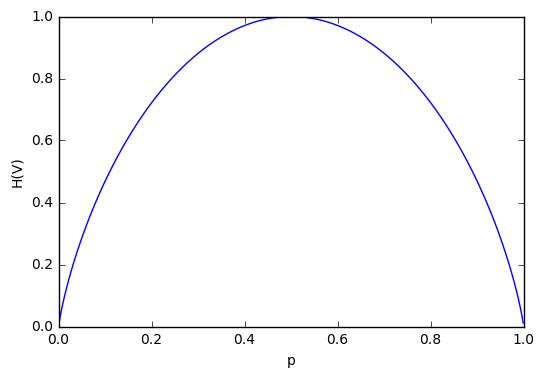

In [3]:
p = np.arange(0.001, 1, 0.001)
plt.plot(p, -p*np.log2(p) - (1-p)*np.log2(1-p))
plt.xlabel('p')
plt.ylabel('H(V)')
plt.show()

Ważne jest to, że kształt wykresu entropii od  P jest gładką funkcją wypukłą i ma gdzieś maksimum
(inna funkcja o podobnych własnościach to np GINI (https://pl.wikipedia.org/wiki/Współczynnik_Giniego)- używana przez statystyków: 

$\qquad$ $\sum_k P(V=k)(1-P(V=k)) $, gdzie k to klasa)

#### Informacja wzajemna (Mutual information)
Informacja wzajemna pomiędzy dwiema zmiennymi losowymi to redukcja entropii  jednej  z nich (A) kiedy poznamy drugą (B):

$\qquad$ $I(A;B) = H(A)-\sum_b P(B=b)\cdot H(A|B=b)$

> Innymi słowy mierzy ona redukcję niepewności o przynależności do klasy jeśli znamy jedną z cech.

* informacja wzajemna jest dobrą miarą do wskazania, którą z cech należy użyć w danym kroku konstrukcji drzewa, bo użycie tej cechy, która ma największa informacje wzajemną z klasami najbardziej zredukuje naszą niepewność.
* można łatwo na obrazku pokazać że funkcja o takim kształcie jak entropia (wykres Entropia(P) ) - ze względu na jej wypukły kształt podział zbioru na dwie części zawsze obniża średnią entropię.

![](zmniejszanie_entropii.png)

## Uczenie drzewa z wartościami, które nie są 0/1

### Wiele wartości dyskretnych 
* można wykonać podział zamiast na dwa liście to na tyle ile jest wartości
* można po kolei przetestować podział względem każdej z wartości po kolei grupując wartości na mniejsze i większe niż pewna wartość
### dla wartości ciągłych 
* wybór progu można oprzeć na przetestowaniu jako możliwego progu każdej z obserwacji w zbiorze uczącym.

### Problem reprezentacji danych

#### Przykład przystość:

* rozróżnienie między tym co można reprezentować, a tym co można nauczyć konkretnym algorytmem

* funkcja parzystości = jak wiele bitów jest 1 ? czy to jest liczba parzysta czy nie? 
  * np. dla 6-cio bitowych wektorów: 
     * [0 1 0 1 1 0] -> nieparzysty ;  
     * [0 1 0 1 1 1] -> parzysty 
  * algorytmy drzewiaste nieźle radzą sobie jeśli przestrzeń cech posiada duże obszary należące do danej klasy -> wtedy podziały kolejnymi płaszczyznami są efektywne
  * problemem są odwzorowania wymagające bardzo dużo podziałów 
  * gdyby mieć właściwą reprezentację danych zadanie z parzystością jest trywialne

### Uczenie z wielowartościowymi cechami 

* kiepskie są cechy o takich wartościach, że są unikalne dla pojedynczych przykładów w zbiorze uczącym (np. NIP) -> nie ma wtedy generalizacji
* Taka cecha niesie sama w sobie bardzo dużo informacji o przykładzie, ale podział zbiory względem tej klasy niekoniecznie musi dawać wiele informacji

## Uczenie z brakującymi wartościami

* nie zawsze jest tak dobrze, że znamy wartości wszystkich cech dla wszystkich przykładów w ciągu uczącym, (ale dla wszystkich znamy ich klasy). Załóżmy że w przykładzie i-tym brakuje wartości dla cechy A. W węźle n-tym drzewa trzeba testować wartość A:
  * dla brakującej cechy można wymusić jakąś wartość np. najbardziej prawdopodobną w całym zbiorze danych
  * nieco lepiej jest wymusić wartość najbardziej prawdopodobną dla klasy do której należy przykład i-ty
  * w pewnym sensie przy dojściu do takiego niepewnego węzła, dla którego brakuje nam danych możemy “rozmnożyć”  ten przykład proporcjonalnie do częstości występowania różnych wartości brakującej cechy w danej klasie. Tzn. załóżmy, że A przyjmuje wartości $v_i$ z prawdopodobieństwem $p_i$ . W dół drzewa wysyłamy frakcje tego przykładu wynoszące $p_i$ 
  * w czasie klasyfikacji po dojściu do liści, patrzymy jak  dużo mamy głosów na daną klasę.

## Problem przeuczenia/ nadmiernego dopasowania 


> Nadmierne dopasowanie mamy wtedy gdy dopasowana przez nas hipoteza $h$ dobrze pasuje do danych treningowych ale ma złą generalizację , tzn. można by było wymyślić lepszą hipotezę $h’$, która może na naszym zbiorze treningowym jest porównywalna z $h$ ale na pełnej przestrzeni cech $h’$ jest lepsza.

## Diagnostyka przeuczania
Musimy podzielić zbiór uczący na treningowy i testowy i patrzeć jak zachowują się miary jakości (np. dokładność ) wraz ze wzrostem skomplikowania drzewa
* można też sprawdzać czy dołożenie podziału najlepszej cechy faktycznie zmienia rozkład klas 
  * co tu znaczy rozkład klas? - w przypadku binarnym czy po podziale w podzbiorze lewym i prawym proporcja pomiędzy klasą 0 i klasą 1 jest istotnie różna do tej proporcji przed podziałem. Na skutek podziałów dążymy do tego żeby np. z lewej wytworzyć same 0 a z prawej same 1)(pre-puning)
* tak jak w innych technikach wzrost skomplikowania hipotezy prowadzi do coraz lepszego dopasowania na zbiorze treningowym, ale powyżej pewnego progu na zbiorze testowym dopasowanie zaczyna się pogarszać.

## Przycinanie drzew 


* post-prune: wyucz drzewo na zbiorze treningowym. Korzystając ze zbioru testowego znajdź te węzły, których usunięcie (wraz ze wszystkimi dalszymi gałęziami) najmniej popsuje wynik(np. dokładność), postępuj tak długo jak długo miara jakość na zbiorze testowym się poprawia (wycinamy gałęzie stanowiące dopasowanie do szczegółów zbioru treningowego)

* wprowadzenie czynnika każącego za stopień skomplikowania drzewa do funkcji mierzącej poprawę dopasowania (regularyzacja)

## Rule Post pruning

* zamiast wycinać gałęzie po prostu, są one zamieniane w zestaw “zasad”
* zasady to zwinięte warunki logiczne. tzn drzewo ma w każdym węźle formułkę 
  * “if A< $\theta$ then left” , 
  * zasada to zwinięcie tych wszystkich węzłów prowadzących do jednego liścia w jeden warunek logiczny połączony “and” np. 
  * “if A<$\theta_1$ & B> $\theta_2$ & C< $\theta_3$ then klasa =0”

* mamy tyle zasad ile liści
* można potem usuwać te których usunięcie powoduje wzrost dokładności na zbiorze testowym

* zasady można ułożyć w kolejności od największej do najmniejszej dokładności i wzg. “przekrycia” tzn. jak wiele przypadków z ciągu uczącego dana reguła obejmuje

# Skalowanie
* algorytmy wymagające losowego dostępu do danych-> dane powinny mieścić się w pamięci
* algorytmy wymagające sekwencyjnego dostępu do danych, po każdym przejściu przez dane aktualizujemy model: dane mogą byś zapisane na dysku  (SPRINT, SLIQ)
* algorytmy działające na strumieniu danych. Założenie jest takie, że algorytm może skorzystać z danych tylko raz (VFDT - very fast decision tree).